In [1]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA

sm.OLS.from_formula

from pmdarima import auto_arima

from pylab import rcParams

In [2]:
#filtro por fecha
def filter_company_data(company_df, start_date, end_date):
    return company_df[(company_df['Date'] >= start_date) & (company_df['Date'] <= end_date)]

# Funcion para convertir signo dolar a numerico
def convert_dollars_to_numerical(value):
    if isinstance(value, str) and re.match(r'\$\d+', value):
        return float(value.replace('$', ''))
    return value

def RMSE(predicted, actual):
    mse = (predicted - actual) ** 2
    rmse = np.sqrt(mse.sum() / mse.count())
    return rmse

In [3]:
df_dow = pd.read_csv('./datasets/indicator_5_years.csv', sep=',')
df_dow.head(10)

,Date,Close/Last,Volume,Open,High,Low
0,05/10/2024,395.18,3505595,395.25,395.8989,394.0958
1,05/09/2024,394.00,4141242,390.11,394.2600,390.0100
2,05/08/2024,390.48,2855082,388.34,390.9100,388.1900
3,05/07/2024,388.74,2428600,389.17,389.7500,388.3400
4,05/06/2024,388.45,2596106,388.32,388.7400,386.8300
5,05/03/2024,386.77,4471092,387.14,387.9900,385.0600
6,05/02/2024,382.23,3535552,381.15,382.9100,378.9000
7,05/01/2024,378.89,5731591,378.38,383.4800,377.9800
8,04/30/2024,378.13,3463622,382.46,382.7490,378.0800
9,04/29/2024,383.80,3265901,383.10,384.0300,382.0700


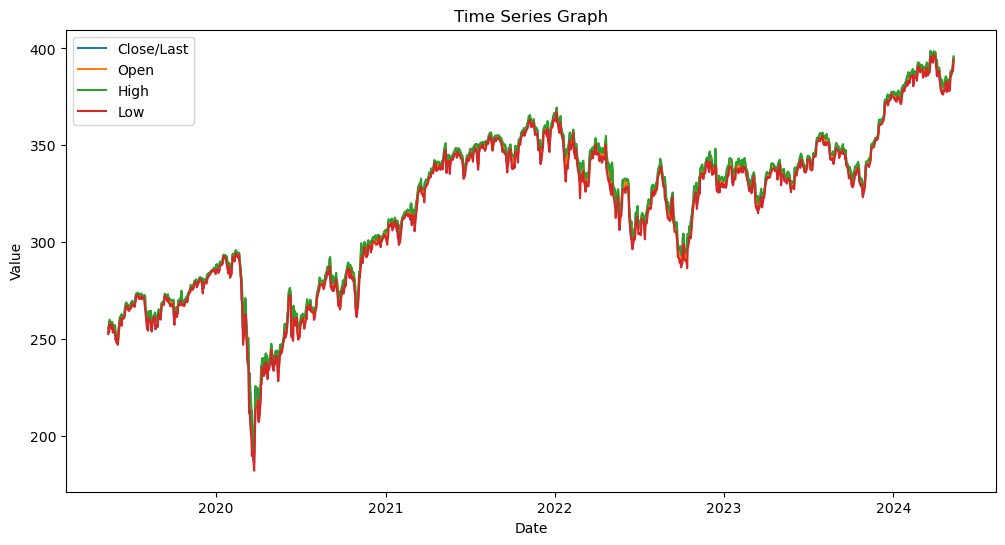

In [4]:
# Plot ilustrativo sobre los valores 'Close/Last', 'Open', 'High' and 'Low'. 

# Sorto las fechas
df_dow = df_dow.sort_values(by = "Date")
df_dow['Date'] = pd.to_datetime(df_dow['Date'])

# Convertir 'Date' a dummy de tiempo
df_dow['Time_index'] = pd.Series(np.arange(len(df_dow['Date'])), index=df_dow.index) 

plt.figure(figsize=(12, 6))
sns.lineplot(x='Date', y='Close/Last', data=df_dow, label='Close/Last')
sns.lineplot(x='Date', y='Open', data=df_dow, label='Open')
sns.lineplot(x='Date', y='High', data=df_dow, label='High')
sns.lineplot(x='Date', y='Low', data=df_dow, label='Low')


plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Time Series Graph')
plt.legend(loc='upper left')

plt.show()


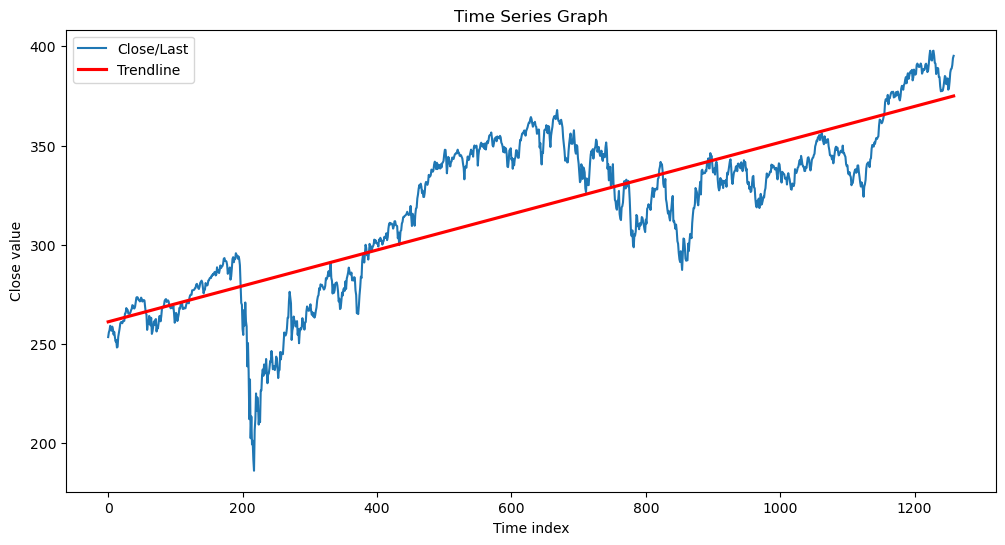

In [5]:
# Plot del valor 'Close/Last' y linea de regresion

# Sorto las fechas
df_dow = df_dow.sort_values(by = "Date")
df_dow['Date'] = pd.to_datetime(df_dow['Date'])

# Convertir 'Date' a dummy de tiempo
df_dow['Time_index'] = pd.Series(np.arange(len(df_dow['Date'])), index=df_dow.index) 

plt.figure(figsize=(12, 6))
sns.lineplot(x='Time_index', y='Close/Last', data=df_dow, label='Close/Last')
sns.regplot(x='Time_index', y='Close/Last', data=df_dow, scatter=False, label='Trendline', ci=None, color='red')


plt.xlabel('Time index')
plt.ylabel('Close value')
plt.title('Time Series Graph')
plt.legend(loc='upper left')

plt.show()

In [6]:
#defino lso nobmres de los csv a utilizar
company_dates = {
"Procter":("2019-05-13", "2024-05-10"),
"3M": ("2019-05-13", "2024-05-10"),
"Merck": ("2019-05-13", "2024-05-10"),
"IBM": ("2019-05-13", "2024-05-10"),
"Amex": ("2019-05-13", "2024-05-10"),
"McDonalds": ("2019-05-13","2024-05-10"),
"Coca": ("2019-05-13", "2024-05-10"),
"Boeing": ("2019-05-13","2024-05-10"),
"JPMorgan": ("2019-05-13", "2024-05-10"),
"Dow": ("2019-05-13","2024-05-10"),
"Disney": ("2019-05-13", "2024-05-10"),
"Caterpillar": ("2019-05-13", "2024-05-10"),
"Walmart": ("2019-05-13","2024-05-10"),
"JNJ": ("2019-05-13", "2024-05-10"),
"Microsoft": ("2019-05-13","2024-05-10"),
"Intel": ("2019-05-13", "2024-05-10"),
"HomeDepot": ("2019-05-13","2024-05-10"),
"Verizon": ("2019-05-13", "2024-05-10"),
"Chevron": ("2019-05-13","2024-05-10"),
"Travelers": ("2019-05-13", "2024-05-10"),
"Cisco": ("2019-05-13","2024-05-10"),
"UnitedHealth": ("2019-05-13", "2024-05-10"),
"Visa": ("2019-05-13","2024-05-10"),
"Nike": ("2019-05-13", "2024-05-10"),
"Apple": ("2019-05-13", "2024-05-10"),
"Goldman": ("2019-04-02","2024-05-10"),
"Salesforce": ("2020-08-31","2024-05-10"),
"Honeywell": ("2020-08-31","2024-05-10"),
"Amgen": ("2020-08-31","2024-05-10"),
"Amazon": ("2024-02-26","2024-05-10"),
"Exxon":("2019-05-13", "2020-08-30"),
"Pfizer": ("2019-05-13","2020-08-30"),
"Raytheon":("2019-05-13", "2020-08-30"),
"Walgreens":("2018-06-26", "2024-02-25"),
}


In [7]:
# Creo nuevo df para mergear 
df_merge = df_dow.copy()

In [8]:
for company, (start_date, end_date) in company_dates.items():
    # cargo dataset de la compañia
    company_df = pd.read_csv(f'./datasets/companies/{company}.csv')
    company_df = company_df.applymap(convert_dollars_to_numerical)
    # Convierto a fecha  la columna date
    company_df['Date'] = pd.to_datetime(company_df['Date'])
    
    # obtengo 
    if company in company_dates:
        start_date, end_date = company_dates[company]
        
        # Filtro por fechas
        filtered_company_df = filter_company_data(company_df, start_date, end_date)
        
        # Mergeo con mi dataset 
        df_merge = pd.merge(df_merge, filtered_company_df, on='Date', how='left', suffixes=('', f'_{company}'))

# Save the merged dataset
df_merge.to_csv('./datasets/merged_dow_jones.csv', index=False)

In [9]:
pd.set_option('display.max_columns', None) 
df_merge.head()

,Date,Close/Last,Volume,Open,High,Low,Time_index,Close/Last_Procter,Volume_Procter,Open_Procter,High_Procter,Low_Procter,Close/Last_3M,Volume_3M,Open_3M,High_3M,Low_3M,Close/Last_Merck,Volume_Merck,Open_Merck,High_Merck,Low_Merck,Close/Last_IBM,Volume_IBM,Open_IBM,High_IBM,Low_IBM,Close/Last_Amex,Volume_Amex,Open_Amex,High_Amex,Low_Amex,Close/Last_McDonalds,Volume_McDonalds,Open_McDonalds,High_McDonalds,Low_McDonalds,Close/Last_Coca,Volume_Coca,Open_Coca,High_Coca,Low_Coca,Close/Last_Boeing,Volume_Boeing,Open_Boeing,High_Boeing,Low_Boeing,Close/Last_JPMorgan,Volume_JPMorgan,Open_JPMorgan,High_JPMorgan,Low_JPMorgan,Close/Last_Dow,Volume_Dow,Open_Dow,High_Dow,Low_Dow,Close/Last_Disney,Volume_Disney,Open_Disney,High_Disney,Low_Disney,Close/Last_Caterpillar,Volume_Caterpillar,Open_Caterpillar,High_Caterpillar,Low_Caterpillar,Close/Last_Walmart,Volume_Walmart,Open_Walmart,High_Walmart,Low_Walmart,Close/Last_JNJ,Volume_JNJ,Open_JNJ,High_JNJ,Low_JNJ,Close/Last_Microsoft,Volume_Microsoft,Open_Microsoft,High_Microsoft,Low_Microsoft,Close/Last_Intel,Volume_Intel,Open_Intel,High_Intel,Low_Intel,Close/Last_HomeDepot,Volume_HomeDepot,Open_HomeDepot,High_HomeDepot,Low_HomeDepot,Close/Last_Verizon,Volume_Verizon,Open_Verizon,High_Verizon,Low_Verizon,Close/Last_Chevron,Volume_Chevron,Open_Chevron,High_Chevron,Low_Chevron,Close/Last_Travelers,Volume_Travelers,Open_Travelers,High_Travelers,Low_Travelers,Close/Last_Cisco,Volume_Cisco,Open_Cisco,High_Cisco,Low_Cisco,Close/Last_UnitedHealth,Volume_UnitedHealth,Open_UnitedHealth,High_UnitedHealth,Low_UnitedHealth,Close/Last_Visa,Volume_Visa,Open_Visa,High_Visa,Low_Visa,Close/Last_Nike,Volume_Nike,Open_Nike,High_Nike,Low_Nike,Close/Last_Apple,Volume_Apple,Open_Apple,High_Apple,Low_Apple,Close/Last_Goldman,Volume_Goldman,Open_Goldman,High_Goldman,Low_Goldman,Close/Last_Salesforce,Volume_Salesforce,Open_Salesforce,High_Salesforce,Low_Salesforce,Close/Last_Honeywell,Volume_Honeywell,Open_Honeywell,High_Honeywell,Low_Honeywell,Close/Last_Amgen,Volume_Amgen,Open_Amgen,High_Amgen,Low_Amgen,Close/Last_Amazon,Volume_Amazon,Open_Amazon,High_Amazon,Low_Amazon,Close/Last_Exxon,Volume_Exxon,Open_Exxon,High_Exxon,Low_Exxon,Close/Last_Pfizer,Volume_Pfizer,Open_Pfizer,High_Pfizer,Low_Pfizer,Close/Last_Raytheon,Volume_Raytheon,Open_Raytheon,High_Raytheon,Low_Raytheon,Close/Last_Walgreens,Volume_Walgreens,Open_Walgreens,High_Walgreens,Low_Walgreens
0,2019-05-13,253.47,6326032,254.67,255.7000,252.59,0,106.11,7575536,105.14,106.590,104.850,149.4209,5916911,149.3050,149.8587,148.3221,74.4746,9200151,74.1368,74.8220,74.1368,127.2023,4958021,129.0026,129.2833,126.7571,115.90,3710632,116.42,116.890,115.62,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,131.34,11389900,131.50,132.66,130.55,125.30,8580682,127.51,127.520,124.080,33.2967,22084637,33.4833,33.7167,33.0033,137.20,5560421,137.85,138.0600,136.5302,123.35,33944920,124.110,125.55,123.04,44.76,39091930,45.33,45.640,44.7000,190.34,3326028,191.00,191.660,189.14,56.75,13759350,56.72,57.34,56.66,120.44,7701636,121.91,122.26,120.0100,143.41,1611771,142.38,143.7900,141.95,51.30,28869930,51.83,52.26,51.06,239.55,4684437,236.45,240.100,236.1974,157.33,9729964,157.19,158.7200,156.4200,82.53,6445267,81.65,82.630,81.32,46.430,229722480,46.9275,47.3700,45.7125,194.97,3605565,197.90,197.90,194.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,75.71,12176300.0,75.65,76.23,75.36,39.6560,26575850.0,39.3237,39.7342,39.2455,78.2462,4119212.0,79.4737,79.8532,77.3153,52.12,5670544.0,52.94,53.0900,51.96
1,2019-05-14,255.81,4308796,254.40,257.2300,254.24,1,105.60,7004005,105.77,106.500,105.570,150.3995,4013992,150.0389,151.9102,149.7986,74.7159,7742178,74.9089,75.3528,74.6580,129.0317,3280374,127.5895,130.0093,127.4540,117.01,2460661,115.98,117.730,115.77,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,133.20,12001740,133.52,134.66,132.05,127.47,401907

In [10]:
# Filtro los datos para crear un nuevo dataframe con los valores de "Date" y "Close/Last"

df_columns = df_merge.columns.values.tolist()

regex = 'Close'
date = 'Date'
list_close_last = [ x for x in df_columns if re.search(regex, x) or re.search(date, x)]

print(list_close_last)

df_close_last = df_merge[list_close_last]


['Date', 'Close/Last', 'Close/Last_Procter', 'Close/Last_3M', 'Close/Last_Merck', 'Close/Last_IBM', 'Close/Last_Amex', 'Close/Last_McDonalds', 'Close/Last_Coca', 'Close/Last_Boeing', 'Close/Last_JPMorgan', 'Close/Last_Dow', 'Close/Last_Disney', 'Close/Last_Caterpillar', 'Close/Last_Walmart', 'Close/Last_JNJ', 'Close/Last_Microsoft', 'Close/Last_Intel', 'Close/Last_HomeDepot', 'Close/Last_Verizon', 'Close/Last_Chevron', 'Close/Last_Travelers', 'Close/Last_Cisco', 'Close/Last_UnitedHealth', 'Close/Last_Visa', 'Close/Last_Nike', 'Close/Last_Apple', 'Close/Last_Goldman', 'Close/Last_Salesforce', 'Close/Last_Honeywell', 'Close/Last_Amgen', 'Close/Last_Amazon', 'Close/Last_Exxon', 'Close/Last_Pfizer', 'Close/Last_Raytheon', 'Close/Last_Walgreens']


In [11]:
df_close_last.head(3)

,Date,Close/Last,Close/Last_Procter,Close/Last_3M,Close/Last_Merck,Close/Last_IBM,Close/Last_Amex,Close/Last_McDonalds,Close/Last_Coca,Close/Last_Boeing,Close/Last_JPMorgan,Close/Last_Dow,Close/Last_Disney,Close/Last_Caterpillar,Close/Last_Walmart,Close/Last_JNJ,Close/Last_Microsoft,Close/Last_Intel,Close/Last_HomeDepot,Close/Last_Verizon,Close/Last_Chevron,Close/Last_Travelers,Close/Last_Cisco,Close/Last_UnitedHealth,Close/Last_Visa,Close/Last_Nike,Close/Last_Apple,Close/Last_Goldman,Close/Last_Salesforce,Close/Last_Honeywell,Close/Last_Amgen,Close/Last_Amazon,Close/Last_Exxon,Close/Last_Pfizer,Close/Last_Raytheon,Close/Last_Walgreens
0,2019-05-13,253.47,106.11,149.4209,74.4746,127.2023,115.90,NaN,NaN,NaN,NaN,NaN,131.34,125.30,33.2967,137.20,123.35,44.76,190.34,56.75,120.44,143.41,51.30,239.55,157.33,82.53,46.430,194.97,NaN,NaN,NaN,NaN,75.71,39.6560,78.2462,52.12
1,2019-05-14,255.81,105.60,150.3995,74.7159,129.0317,117.01,NaN,NaN,NaN,NaN,NaN,133.20,127.47,33.4300,136.82,124.73,45.17,191.62,56.55,121.64,145.71,52.02,236.43,160.21,83.67,47.165,196.28,NaN,NaN,NaN,NaN,75.81,39.7440,79.4440,52.58
2,2019-05-15,256.92,106.70,149.4638,74.8413,130.0867,117.66,NaN,NaN,NaN,NaN,NaN,134.68,127.30,33.2933,136.91,126.02,45.62,191.76,56.81,122.14,146.52,52.44,236.08,162.79,84.01,47.730,196.40,NaN,NaN,NaN,NaN,76.37,40.2229,79.4440,52.74


In [12]:
# Renombrar columnas para mayor claridad
rename_function = lambda name: 'Index' if name == 'Close/Last' else name.split('_')[-1]

# Funcion para renombrar
new_column_names = list(map(rename_function, list_close_last))

df_close_last.rename(columns=dict(zip(df_close_last.columns, new_column_names)), inplace=True)

df_close_last.head()

C:\Users\juan\AppData\Local\Temp\ipykernel_3220\4002656954.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_close_last.rename(columns=dict(zip(df_close_last.columns, new_column_names)), inplace=True)


,Date,Index,Procter,3M,Merck,IBM,Amex,McDonalds,Coca,Boeing,JPMorgan,Dow,Disney,Caterpillar,Walmart,JNJ,Microsoft,Intel,HomeDepot,Verizon,Chevron,Travelers,Cisco,UnitedHealth,Visa,Nike,Apple,Goldman,Salesforce,Honeywell,Amgen,Amazon,Exxon,Pfizer,Raytheon,Walgreens
0,2019-05-13,253.47,106.11,149.4209,74.4746,127.2023,115.90,NaN,NaN,NaN,NaN,NaN,131.34,125.30,33.2967,137.20,123.35,44.76,190.34,56.75,120.44,143.41,51.30,239.55,157.33,82.53,46.430,194.97,NaN,NaN,NaN,NaN,75.71,39.6560,78.2462,52.12
1,2019-05-14,255.81,105.60,150.3995,74.7159,129.0317,117.01,NaN,NaN,NaN,NaN,NaN,133.20,127.47,33.4300,136.82,124.73,45.17,191.62,56.55,121.64,145.71,52.02,236.43,160.21,83.67,47.165,196.28,NaN,NaN,NaN,NaN,75.81,39.7440,79.4440,52.58
2,2019-05-15,256.92,106.70,149.4638,74.8413,130.0867,117.66,NaN,NaN,NaN,NaN,NaN,134.68,127.30,33.2933,136.91,126.02,45.62,191.76,56.81,122.14,146.52,52.44,236.08,162.79,84.01,47.730,196.40,NaN,NaN,NaN,NaN,76.37,40.2229,79.4440,52.74
3,2019-05-16,259.16,108.11,147.4809,76.3661,131.5192,119.84,199.99,49.58,353.81,111.31,52.98,135.50,126.61,33.7700,138.21,128.93,45.53,192.38,57.38,120.80,147.41,55.93,236.79,164.87,84.28,47.520,199.14,NaN,NaN,NaN,NaN,76.36,40.7019,80.1971,52.50
4,2019-05-17,257.44,107.45,145.1461,75.9705,130.0093,119.07,199.22,49.20,355.02,110.77,50.80,135.04,122.76,33.6200,138.61,128.07,44.89,192.58,58.09,120.52,147.49,56.35,241.38,164.09,84.57,47.250,197.43,NaN,NaN,NaN,NaN,75.91,40.5357,79.3076,52.27


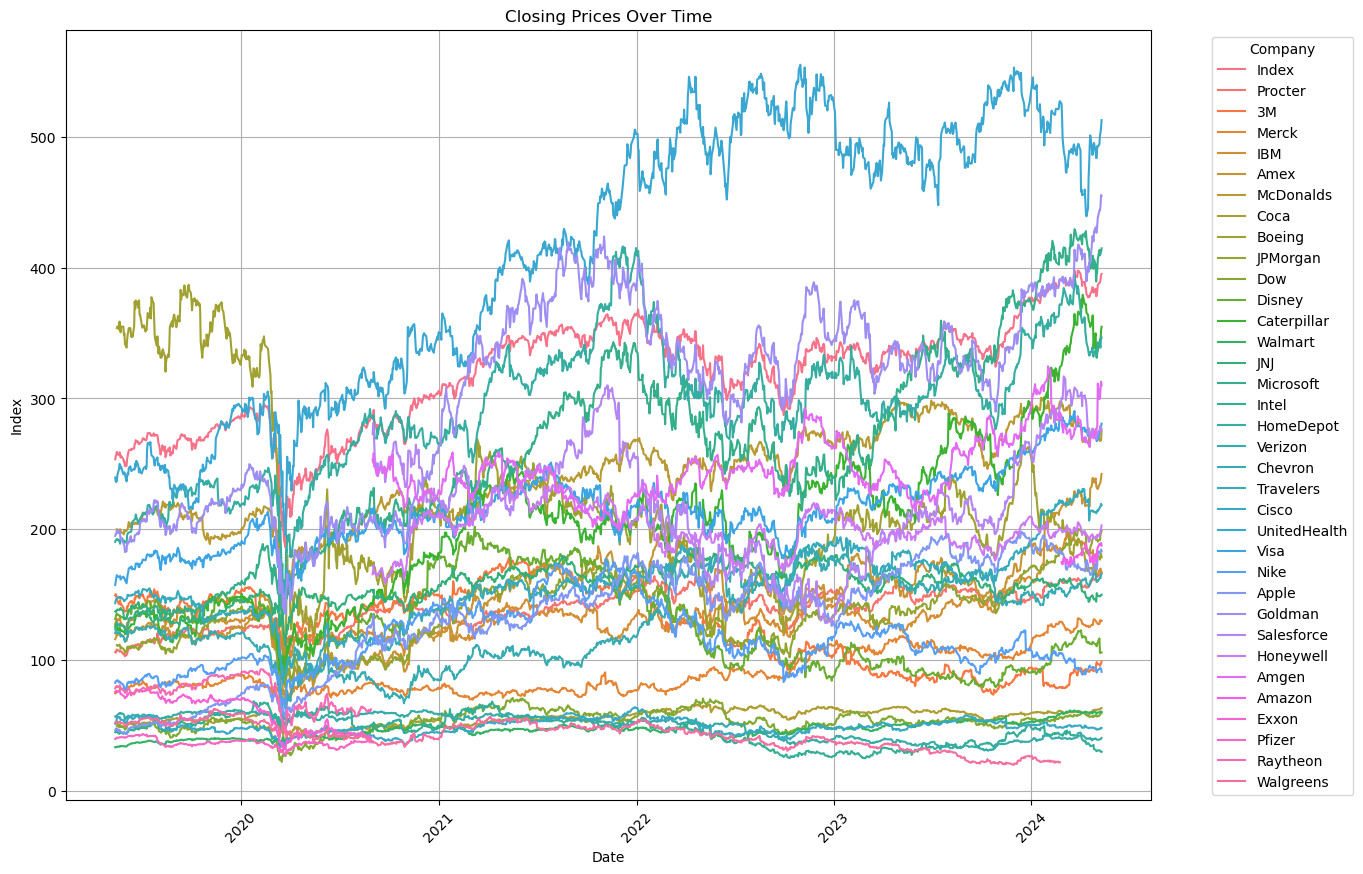

In [13]:
# Plot de los valores para cada empresa

melted_df = df_close_last.melt(id_vars=['Date'], var_name='Company', value_name='Close_value')

plt.figure(figsize=(14, 10))
sns.lineplot(data=melted_df, x='Date', y='Close_value', hue='Company')

plt.title('Closing Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Index')
plt.legend(title='Company', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [14]:
# Correlaciones:

# Matriz de correlacion
correlation_matrix = df_close_last.corr()
print(correlation_matrix)


                  Date     Index   Procter        3M     Merck       IBM  \
Date          1.000000  0.812762  0.822364 -0.750303  0.812223  0.578149   
Index         0.812762  1.000000  0.859556 -0.291794  0.577563  0.652232   
Procter       0.822364  0.859556  1.000000 -0.420867  0.587033  0.477098   
3M           -0.750303 -0.291794 -0.420867  1.000000 -0.839521 -0.426505   
Merck         0.812223  0.577563  0.587033 -0.839521  1.000000  0.700250   
IBM           0.578149  0.652232  0.477098 -0.426505  0.700250  1.000000   
Amex          0.767736  0.925216  0.769889 -0.352470  0.618962  0.714243   
McDonalds     0.904501  0.847611  0.831443 -0.630658  0.787962  0.597174   
Coca          0.693199  0.694803  0.735629 -0.457999  0.624176  0.496240   
Boeing       -0.506327 -0.217270 -0.438399  0.339455 -0.173217  0.098658   
JPMorgan      0.597153  0.889657  0.633673 -0.125154  0.473040  0.691686   
Dow           0.326181  0.709756  0.531877  0.241455  0.091838  0.309836   
Disney      

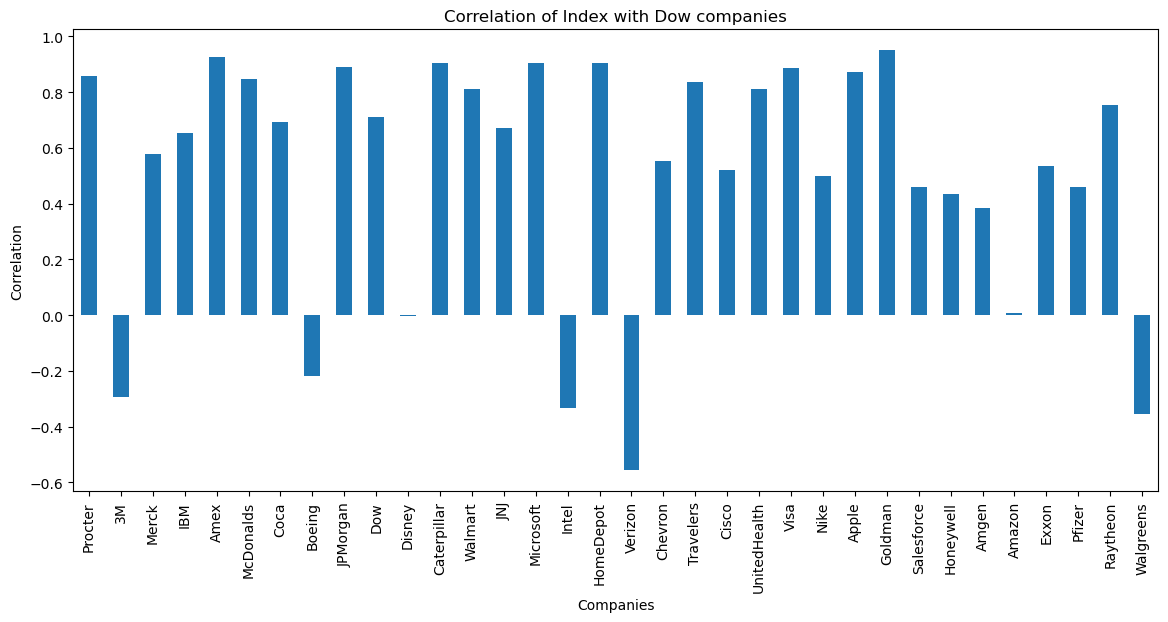

In [15]:
# Correlacion de las empresas con el Dow Index
# Son demasiadas empresas, por lo tanto las correlaciones se muestran mejor como grafico de histogramas
# Transposicion de la matriz
correlation_matrix = correlation_matrix[['Index']].transpose()

# Todas las correlaciones a partir de la segunda columna
correlations = correlation_matrix.loc['Index', 'Procter':]

# Plot 
plt.figure(figsize=(14, 6))
correlations.plot(kind='bar')
plt.xlabel('Companies')
plt.ylabel('Correlation')
plt.title('Correlation of Index with Dow companies')
plt.xticks(rotation=90, fontsize=10)
plt.show()

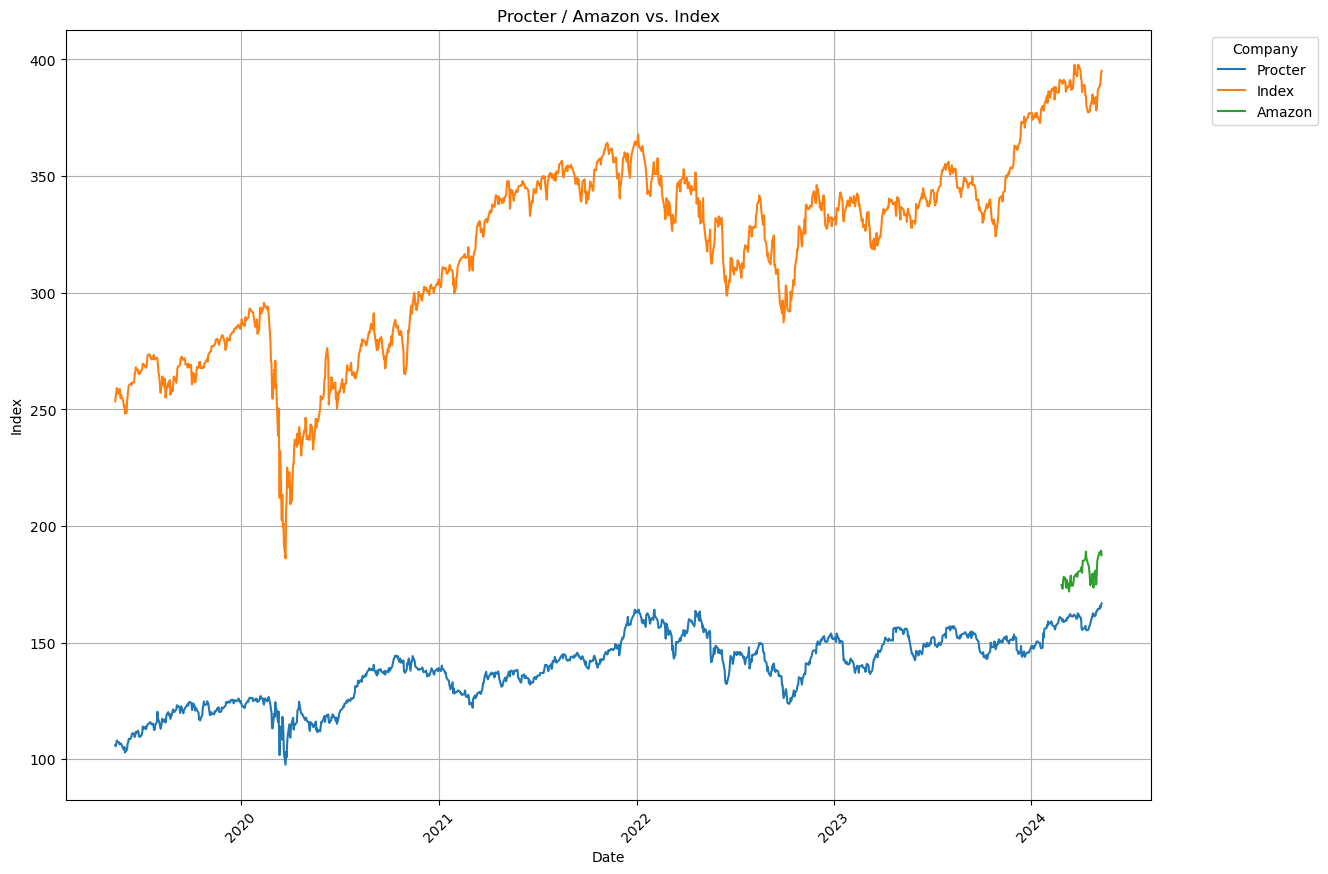

In [16]:
# Porque la correlacion de Amazon es tan baja respecto al Index? 
# Porque se sumó hace muy poco tiempo. 
# Ver la comparacion con Procter (la mas antigua)

plt.figure(figsize=(14, 10))
sns.lineplot(x='Date', y='Procter', data=df_close_last, label='Procter')
sns.lineplot(x='Date', y='Index', data=df_close_last, label='Index')
sns.lineplot(x='Date', y='Amazon', data=df_close_last, label='Amazon')

plt.title('Procter / Amazon vs. Index')
plt.xlabel('Date')
plt.ylabel('Index')
plt.legend(title='Company', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [17]:
df_close_last.head(2)

,Date,Index,Procter,3M,Merck,IBM,Amex,McDonalds,Coca,Boeing,JPMorgan,Dow,Disney,Caterpillar,Walmart,JNJ,Microsoft,Intel,HomeDepot,Verizon,Chevron,Travelers,Cisco,UnitedHealth,Visa,Nike,Apple,Goldman,Salesforce,Honeywell,Amgen,Amazon,Exxon,Pfizer,Raytheon,Walgreens
0,2019-05-13,253.47,106.11,149.4209,74.4746,127.2023,115.90,NaN,NaN,NaN,NaN,NaN,131.34,125.30,33.2967,137.20,123.35,44.76,190.34,56.75,120.44,143.41,51.30,239.55,157.33,82.53,46.430,194.97,NaN,NaN,NaN,NaN,75.71,39.656,78.2462,52.12
1,2019-05-14,255.81,105.60,150.3995,74.7159,129.0317,117.01,NaN,NaN,NaN,NaN,NaN,133.20,127.47,33.4300,136.82,124.73,45.17,191.62,56.55,121.64,145.71,52.02,236.43,160.21,83.67,47.165,196.28,NaN,NaN,NaN,NaN,75.81,39.744,79.4440,52.58


['Procter', '3M', 'Merck', 'IBM', 'Amex', 'McDonalds', 'Coca', 'Boeing', 'JPMorgan', 'Dow', 'Disney', 'Caterpillar', 'Walmart', 'JNJ', 'Microsoft', 'Intel', 'HomeDepot', 'Verizon', 'Chevron', 'Travelers', 'Cisco', 'UnitedHealth', 'Visa', 'Nike', 'Apple', 'Goldman', 'Salesforce', 'Honeywell', 'Amgen', 'Amazon', 'Exxon', 'Pfizer', 'Raytheon', 'Walgreens']
Explained variance by component: [0.44946028 0.17524982 0.10822486 0.07324802 0.0328235 ]
          Index      Date           PC1           PC2           PC3  \
Index  1.000000  0.812762 -9.281373e-01 -3.589267e-01  4.393145e-02   
Date   0.812762  1.000000 -9.562612e-01  2.313483e-01  1.178699e-01   
PC1   -0.928137 -0.956261  1.000000e+00  4.420094e-16  5.458384e-16   
PC2   -0.358927  0.231348  4.420094e-16  1.000000e+00 -2.177911e-16   
PC3    0.043931  0.117870  5.458384e-16 -2.177911e-16  1.000000e+00   
PC4    0.036181  0.007253  3.654759e-16 -5.015581e-17 -4.194755e-17   
PC5   -0.000357 -0.016583 -1.161626e-17 -8.921922e-17  3.

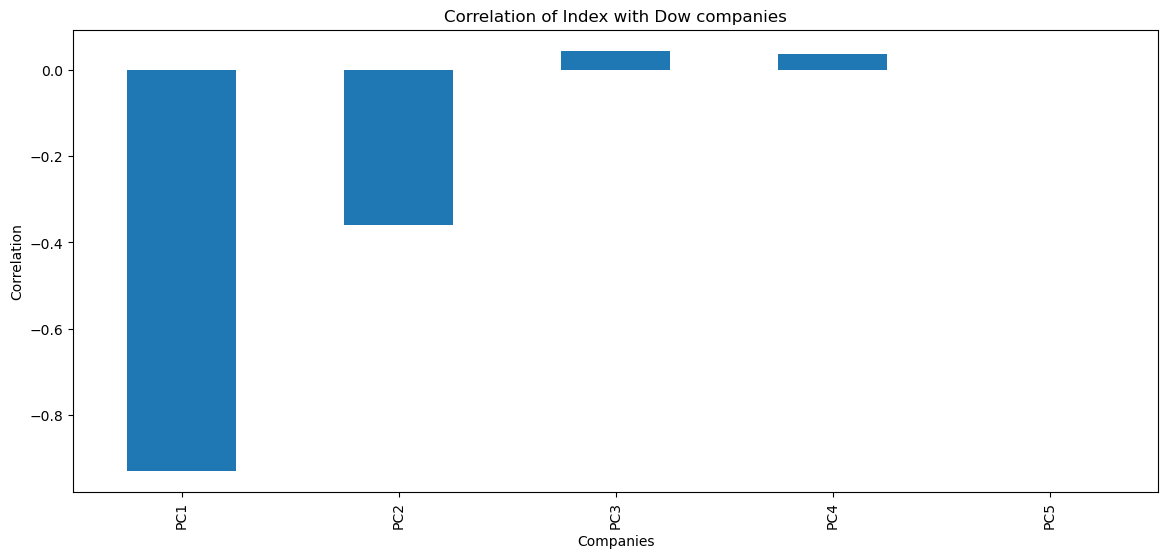

In [18]:
#Selecciono mis features
features = [col for col in df_close_last.columns]
features.remove('Date')
features.remove('Index')
#features = [col for col in df_close_last.columns if col not in ['Date', 'Index']]
print(features)
# Extrigo
feature_data = df_close_last[features].fillna(df_close_last.mean())

# Normalizo
scaler = StandardScaler()
scaled_feature_data = scaler.fit_transform(feature_data)

# Aplico pca
pca = PCA(n_components=5) 
principal_components = pca.fit_transform(scaled_feature_data)

# Creo DF para los componentes principales 
pc_df = pd.DataFrame(data=principal_components, columns=[f'PC{i+1}' for i in range(principal_components.shape[1])])

df_close_last = pd.concat([df_close_last[['Index']],df_close_last[['Date']], pc_df], axis=1)
df_close_last.head()

# Ratio de Varianza
explained_variance = pca.explained_variance_ratio_
print('Explained variance by component:', explained_variance)

# Correlaciones:

# Matriz de correlacion
correlation_matrix = df_close_last.corr()
print(correlation_matrix)

# Correlacion de las empresas con el Dow Index
# Son demasiadas empresas, por lo tanto las correlaciones se muestran mejor como grafico de histogramas
# Transposicion de la matriz
correlation_matrix = correlation_matrix[['Index']].transpose()

# Todas las correlaciones a partir de la segunda columna
correlations = correlation_matrix.loc['Index', 'PC1':]

# Plot 
plt.figure(figsize=(14, 6))
correlations.plot(kind='bar')
plt.xlabel('Companies')
plt.ylabel('Correlation')
plt.title('Correlation of Index with Dow companies')
plt.xticks(rotation=90, fontsize=10)
plt.show()

# Modelo ARIMA, hay que revisar

In [23]:
df_close_last.head(2)

,Index,Date,PC1,PC2,PC3,PC4,PC5
0,253.47,2019-05-13,5.053996,-0.023843,-3.729203,-0.791531,-0.171415
1,255.81,2019-05-14,4.962109,-0.171981,-3.868583,-0.751666,-0.193564


In [24]:
dfa = df_close_last.copy()

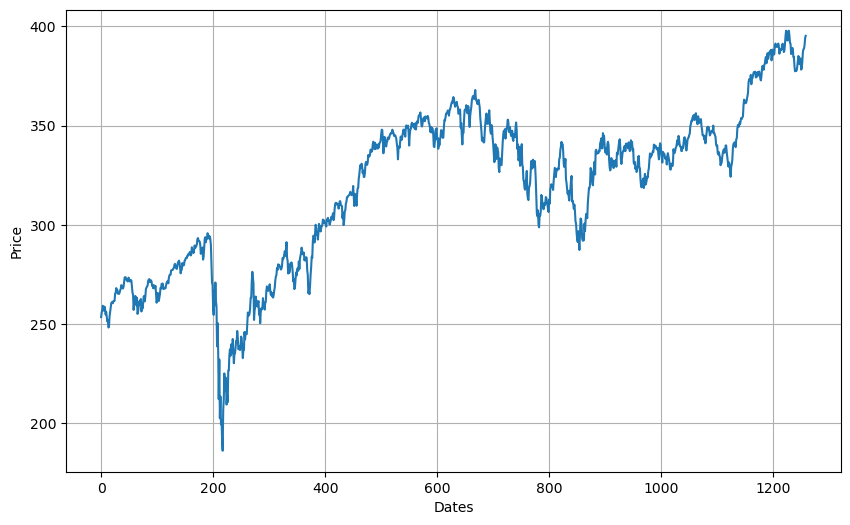

In [27]:
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Price')
plt.plot(dfa['Index'])
plt.show()

In [28]:
dfa_train, dfa_test = train_test_split(dfa, test_size=300, random_state=2024, shuffle=False)

In [29]:
dfa_train.columns

Index(['Index', 'Date', 'PC1', 'PC2', 'PC3', 'PC4', 'PC5'], dtype='object')

In [30]:
#columns = (['PC1', 'PC2', 'PC3', 'PC4', 'PC5'])
columns = (['PC1', 'PC2', 'PC3', 'PC4', 'PC5'])
modela = auto_arima(y = dfa_train['Index'], exogenous = dfa_train[columns], trace = True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=5246.433, Time=0.42 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5319.227, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5302.882, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5306.218, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5317.639, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=5294.954, Time=0.14 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=5296.299, Time=0.10 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=5245.232, Time=0.36 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=5297.674, Time=0.27 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=5247.143, Time=0.70 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.84 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=5297.925, Time=0.34 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=5254.044, Time=0.38 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=5247.559, Time=0.86 sec
 ARIMA(3,1,2)(0,0,0)[0]             : 

In [31]:
modela.fit(dfa_train['Index'],dfa_train[columns])

ARIMA(order=(3, 1, 2), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [32]:
# Ajustar el modelo con datos de entrenamiento
modela = ARIMA(dfa_train['Index'], exog=dfa_train[columns], order = (3,1,2))
modela_fit = modela.fit()

# Predecir con datos de prueba
forecasta2 = modela_fit.predict(start=len(dfa_train), end=len(dfa_train) + len(dfa_test) - 1, exog=dfa_test[columns])

# Mostrar resultados
print(forecasta2)

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


959     334.045297
960     334.368257
961     328.914894
962     328.398833
963     323.073187
           ...    
1254    391.134061
1255    392.465273
1256    394.399089
1257    396.536273
1258    398.249357
Name: predicted_mean, Length: 300, dtype: float64


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


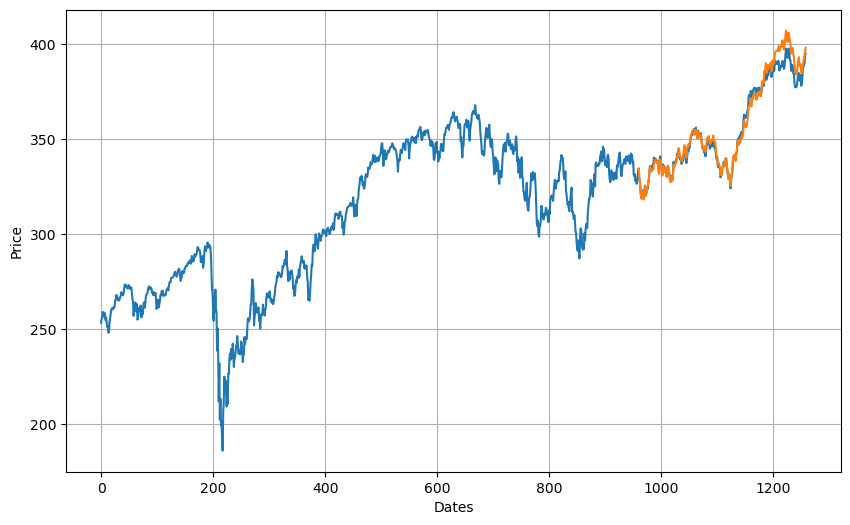

In [35]:
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Price')
plt.plot(dfa['Index'])
plt.plot(forecasta2)
plt.show()

In [45]:
RMSE(forecasta2,dfa_test['Index'])

3.991344485721643

In [44]:
dfb = dfa.copy()
columns = (['PC1', 'PC2', 'PC3', 'PC4', 'PC5'])
target_column = 'Index'

# Asegurarse de que 'Date' esté en el índice
dfb['Date'] = pd.to_datetime(dfb['Date'])
dfb.set_index('Date', inplace=True)

# Ajustar el modelo ARIMA con todos los datos disponibles
modela = ARIMA(dfb[target_column], exog=dfb[columns])
modela_fit = modela.fit()

# Crear DataFrame para los próximos 60 días
last_date = dfb.index[-1]
future_dates = pd.date_range(start=last_date, periods=61, inclusive='right')

# Generar tendencias para las variables exógenas futuras (esto es solo un ejemplo)
future_exog = pd.DataFrame(index=future_dates)

for col in columns:
    # Preparar los datos para la regresión lineal
    X = np.arange(len(df_close_last)).reshape(-1, 1)
    y = df_close_last[col].values
    
    # Ajustar el modelo de regresión lineal
    model_exog = LinearRegression()
    model_exog.fit(X, y)
    
    # Predecir los próximos 60 días
    X_future = np.arange(len(df_close_last), len(df_close_last) + 60).reshape(-1, 1)
    future_exog[col] = model_exog.predict(X_future)



# Predecir los próximos 60 registros si no hay NaN en future_exog
if not future_exog.isnull().values.any():
    forecasta_future = modela_fit.forecast(steps=60, exog=future_exog)
    # Mostrar resultados
    #print(forecasta_future)
else:
    print("Future exogenous variables contain NaN values. Please check the models.")

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ValueError: Length of values (100) does not match length of index (60)

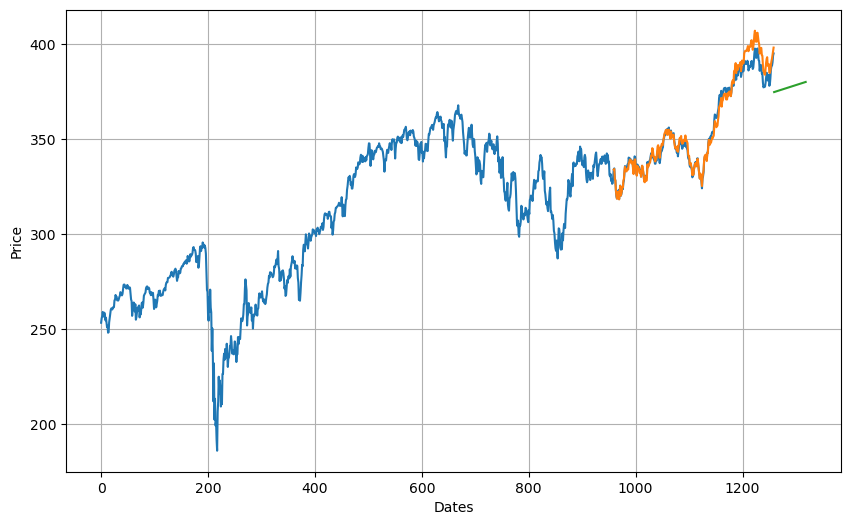

In [38]:
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Price')
plt.plot(dfa['Index'])
plt.plot(forecasta2)
plt.plot(forecasta_future)
plt.show()